
# Clase 1 — Datos (FK.xlsx)

Este cuaderno ipynb realizamos **paso a paso** el flujo de la **Clase 1** usando el archivo `FK.xlsx`
y genera los resultados y figuras:

- Carga y estandarización (trimestral)
- Est. Descriptivos y visualización
- Transformaciones (deltas, crecimientos, normalizaciones, log, raiz, Box-Cox)
- Volatilidad (desv. est. móvil)
- Picos y valles (ciclos)
- Outliers (IQR)
- Medias móviles (4 y 8 trimestres)
- Brecha del PIB (HP filter)
- Cambio de régimen (prueba de quiebre simple tipo sup-F)
- Rachas de expansión/contracción
- Índice base 100
- Correlación con rezagos
- Export consolidado de resultados

**Archivos de entrada**
- `/data/FK.xlsx` — hojas: `Trimestral` (principal), `Anual` (opcional).

**Archivos de salida** (se guardan en `/data/out/`)
- `m1_resultados_pipeline.csv`, `iqr_bounds.csv`, `break_result.json`
- `plot_*.png` (todas las figuras)

> **Nota**: Si ejecutas localmente, ajusta las rutas a tus carpetas.



## 1) Dependencias
Este proyecto usa: `pandas`, `numpy`, `matplotlib`, `scipy`, `statsmodels`.

Si te falta algún paquete, descomenta y ejecuta:


In [2]:
pip install pandas numpy matplotlib scipy statsmodels

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.



## 2) Imports y configuración


In [4]:
import os, json, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

warnings.filterwarnings("ignore")



In [7]:
pip install openpyxl


   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpy


## 3) Carga y estandarización de `FK.xlsx`

- Leemos la **hoja Trimestral** y normalizamos nombres de columnas.
- Convertimos la columna `fecha` a tipo fecha y generamos `PeriodIndex` trimestral.
- Creamos `pib_a`: suma móvil de 4 trimestres (PIB acumulado).


In [8]:
# 2) Leer la hoja 'Trimestral' 
df_q = pd.read_excel("C:/Users/Usuario/Documents/Curso de Econometría, Análisis de Datos e IA con Software/Modulo 4. Microeconometría y Análisis de Datos/MACROECONOMETRÍA Y ANÁLISIS DE DATOS/Clase 14_09_2025 v2/code_01/data/FK.xlsx", sheet_name="Trimestral")
df_q

,fecha,PiB,itcr,TC,Inf,infe
0,1990-03-01,3.587595e+06,NaN,3.0703,NaN,NaN
1,1990-06-01,3.926068e+06,NaN,3.1477,NaN,NaN
2,1990-09-01,3.934133e+06,NaN,3.2410,NaN,NaN
3,1990-12-01,3.995340e+06,NaN,3.3748,NaN,NaN
4,1991-03-01,3.677806e+06,89.805307,3.5019,0.244011,5.779607
...,...,...,...,...,...,...
135,2023-12-01,1.398874e+07,60.180628,6.9600,0.021183,0.046211
136,2024-03-01,1.224718e+07,62.187154,6.9600,0.030675,0.039278
137,2024-06-01,1.283672e+07,63.451485,6.9600,0.038444,0.042276
138,2024-09-01,NaN,61.798842,6.9600,0.061821,0.044247


Mostrar las primeras filas del DataFrame.

In [296]:
df_q.head(3)

,fecha,PiB,itcr,TC,Inf,infe
0,1990-03-01,3.587595e+06,NaN,3.0703,NaN,NaN
1,1990-06-01,3.926068e+06,NaN,3.1477,NaN,NaN
2,1990-09-01,3.934133e+06,NaN,3.2410,NaN,NaN


Mostrar las últimas filas del DataFrame.

In [297]:
df_q.tail(3)

,fecha,PiB,itcr,TC,Inf,infe
137,2024-06-01,1.283672e+07,63.451485,6.96,0.038444,0.042276
138,2024-09-01,NaN,61.798842,6.96,0.061821,0.044247
139,NaT,NaN,NaN,6.96,0.099739,0.048313


Mostrar los estadisticos descriptivos básicos.

In [298]:
df_q.describe()

,fecha,PiB,itcr,TC,Inf,infe
count,139,1.380000e+02,135.000000,140.000000,136.000000,136.000000
mean,2007-06-01 11:03:01.294963968,7.808784e+06,85.643288,6.426292,0.056370,1.847767
min,1990-03-01 00:00:00,3.587595e+06,56.240788,3.070300,-0.000248,0.016560
25%,1998-10-16 12:00:00,5.301440e+06,64.104176,5.619000,0.025853,0.045717
50%,2007-06-01 00:00:00,7.050418e+06,92.291208,6.960000,0.042844,0.062957
75%,2016-01-15 12:00:00,1.066850e+07,98.771638,7.017258,0.075660,0.094135
max,2024-09-01 00:00:00,1.398874e+07,113.778901,8.100000,0.244011,50.026811
std,NaN,2.959865e+06,17.925564,1.278821,0.046208,6.461169


Mostrar las dimensiones del DataFrame (filas, columnas).

In [299]:
df_q.shape

(140, 6)

Impripir las columnas del DataFrame.

In [300]:
df_q.columns

Index(['fecha', 'PiB', 'itcr', 'TC', 'Inf', 'infe'], dtype='object')

Tipos de variables del dataframe.

In [301]:
df_q.dtypes

fecha    datetime64[ns]
PiB             float64
itcr            float64
TC              float64
Inf             float64
infe            float64
dtype: object

In [302]:
df_q

,fecha,PiB,itcr,TC,Inf,infe
0,1990-03-01,3.587595e+06,NaN,3.0703,NaN,NaN
1,1990-06-01,3.926068e+06,NaN,3.1477,NaN,NaN
2,1990-09-01,3.934133e+06,NaN,3.2410,NaN,NaN
3,1990-12-01,3.995340e+06,NaN,3.3748,NaN,NaN
4,1991-03-01,3.677806e+06,89.805307,3.5019,0.244011,5.779607
...,...,...,...,...,...,...
135,2023-12-01,1.398874e+07,60.180628,6.9600,0.021183,0.046211
136,2024-03-01,1.224718e+07,62.187154,6.9600,0.030675,0.039278
137,2024-06-01,1.283672e+07,63.451485,6.9600,0.038444,0.042276
138,2024-09-01,NaN,61.798842,6.9600,0.061821,0.044247


In [303]:
# Normalizamos los nombres de columnas para evitar problemas de mayúsculas/espacios.
#    Quedarán en minúsculas y sin espacios al inicio/fin (p.ej., "Fecha " -> "fecha").
df_q.columns = [c.strip().lower() for c in df_q.columns]
df_q.tail()

,fecha,pib,itcr,tc,inf,infe
135,2023-12-01,1.398874e+07,60.180628,6.96,0.021183,0.046211
136,2024-03-01,1.224718e+07,62.187154,6.96,0.030675,0.039278
137,2024-06-01,1.283672e+07,63.451485,6.96,0.038444,0.042276
138,2024-09-01,NaN,61.798842,6.96,0.061821,0.044247
139,NaT,NaN,NaN,6.96,0.099739,0.048313


In [304]:
df_q.head()

,fecha,pib,itcr,tc,inf,infe
0,1990-03-01,3.587595e+06,NaN,3.0703,NaN,NaN
1,1990-06-01,3.926068e+06,NaN,3.1477,NaN,NaN
2,1990-09-01,3.934133e+06,NaN,3.2410,NaN,NaN
3,1990-12-01,3.995340e+06,NaN,3.3748,NaN,NaN
4,1991-03-01,3.677806e+06,89.805307,3.5019,0.244011,5.779607


In [305]:
# Quitamos filas donde falten los campos clave: fecha y pib.
#    Esto evita errores en las transformaciones y asegura consistencia.
df_q = df_q.dropna(subset=["fecha", "pib"])
df_q.tail()

,fecha,pib,itcr,tc,inf,infe
133,2023-06-01,1.236487e+07,60.059236,6.96,0.027253,0.031615
134,2023-09-01,1.250127e+07,60.008669,6.96,0.028478,0.045683
135,2023-12-01,1.398874e+07,60.180628,6.96,0.021183,0.046211
136,2024-03-01,1.224718e+07,62.187154,6.96,0.030675,0.039278
137,2024-06-01,1.283672e+07,63.451485,6.96,0.038444,0.042276


In [306]:
df_q.head()

,fecha,pib,itcr,tc,inf,infe
0,1990-03-01,3.587595e+06,NaN,3.0703,NaN,NaN
1,1990-06-01,3.926068e+06,NaN,3.1477,NaN,NaN
2,1990-09-01,3.934133e+06,NaN,3.2410,NaN,NaN
3,1990-12-01,3.995340e+06,NaN,3.3748,NaN,NaN
4,1991-03-01,3.677806e+06,89.805307,3.5019,0.244011,5.779607


In [307]:
# Convertimos la columna 'fecha' a datetime. 
#    Es importante para poder derivar el período trimestral correctamente.
df_q["fecha"] = pd.to_datetime(df_q["fecha"])
df_q.round(1)

,fecha,pib,itcr,tc,inf,infe
0,1990-03-01,3587595.3,NaN,3.1,NaN,NaN
1,1990-06-01,3926068.4,NaN,3.1,NaN,NaN
2,1990-09-01,3934132.6,NaN,3.2,NaN,NaN
3,1990-12-01,3995340.2,NaN,3.4,NaN,NaN
4,1991-03-01,3677805.8,89.8,3.5,0.2,5.8
...,...,...,...,...,...,...
133,2023-06-01,12364865.9,60.1,7.0,0.0,0.0
134,2023-09-01,12501266.2,60.0,7.0,0.0,0.0
135,2023-12-01,13988740.0,60.2,7.0,0.0,0.0
136,2024-03-01,12247180.0,62.2,7.0,0.0,0.0


In [308]:
# Construimos un índice trimestral (PeriodIndex). 
#    A partir de la fecha calendario, extraemos el trimestre al que pertenece.
df_q["periodo_q"] = df_q["fecha"].dt.to_period("Q")
df_q[["fecha", "periodo_q"]].head(10)

,fecha,periodo_q
0,1990-03-01,1990Q1
1,1990-06-01,1990Q2
2,1990-09-01,1990Q3
3,1990-12-01,1990Q4
4,1991-03-01,1991Q1
5,1991-06-01,1991Q2
6,1991-09-01,1991Q3
7,1991-12-01,1991Q4
8,1992-03-01,1992Q1
9,1992-06-01,1992Q2


In [309]:
# Establecemos el índice del DataFrame como el período trimestral y ordenamos.
#    Esto facilita operaciones temporales (diff, rolling, resample, etc.).
df_q = df_q.set_index("periodo_q").sort_index()
df_q

,fecha,pib,itcr,tc,inf,infe
periodo_q,,,,,,
1990Q1,1990-03-01,3.587595e+06,NaN,3.0703,NaN,NaN
1990Q2,1990-06-01,3.926068e+06,NaN,3.1477,NaN,NaN
1990Q3,1990-09-01,3.934133e+06,NaN,3.2410,NaN,NaN
1990Q4,1990-12-01,3.995340e+06,NaN,3.3748,NaN,NaN
1991Q1,1991-03-01,3.677806e+06,89.805307,3.5019,0.244011,5.779607
...,...,...,...,...,...,...
2023Q2,2023-06-01,1.236487e+07,60.059236,6.9600,0.027253,0.031615
2023Q3,2023-09-01,1.250127e+07,60.008669,6.9600,0.028478,0.045683
2023Q4,2023-12-01,1.398874e+07,60.180628,6.9600,0.021183,0.046211


In [310]:
# PIB acumulado en 4 trimestres (suma móvil). 
#    Equivale a un TTM (trailing twelve months) pero en frecuencia trimestral.
#    Nota: los primeros 3 trimestres darán NaN porque no hay suficientes datos previos.
df_q["pib_a"] = df_q["pib"].rolling(4).sum()
df_q[["pib", "pib_a"]].head(10).round(1)

,pib,pib_a
periodo_q,,
1990Q1,3587595.3,NaN
1990Q2,3926068.4,NaN
1990Q3,3934132.6,NaN
1990Q4,3995340.2,15443136.5
1991Q1,3677805.8,15533347.0
1991Q2,4217984.3,15825262.9
1991Q3,4149574.9,16040705.2
1991Q4,4211087.6,16256452.7
1992Q1,3795755.9,16374402.7


In [311]:
# Guardamos una versión estandarizada del DataFrame para auditoría/reuso.
#    Se incluye el índice (periodo_q) en el CSV.
df_q.to_csv("output/tables/m1_q_standardized.csv", index=True)

In [312]:
# Mostramos las primeras filas para verificar el resultado.
df_q.head()

,fecha,pib,itcr,tc,inf,infe,pib_a
periodo_q,,,,,,,
1990Q1,1990-03-01,3.587595e+06,NaN,3.0703,NaN,NaN,NaN
1990Q2,1990-06-01,3.926068e+06,NaN,3.1477,NaN,NaN,NaN
1990Q3,1990-09-01,3.934133e+06,NaN,3.2410,NaN,NaN,NaN
1990Q4,1990-12-01,3.995340e+06,NaN,3.3748,NaN,NaN,1.544314e+07
1991Q1,1991-03-01,3.677806e+06,89.805307,3.5019,0.244011,5.779607,1.553335e+07


In [313]:
df_q.head()

,fecha,pib,itcr,tc,inf,infe,pib_a
periodo_q,,,,,,,
1990Q1,1990-03-01,3.587595e+06,NaN,3.0703,NaN,NaN,NaN
1990Q2,1990-06-01,3.926068e+06,NaN,3.1477,NaN,NaN,NaN
1990Q3,1990-09-01,3.934133e+06,NaN,3.2410,NaN,NaN,NaN
1990Q4,1990-12-01,3.995340e+06,NaN,3.3748,NaN,NaN,1.544314e+07
1991Q1,1991-03-01,3.677806e+06,89.805307,3.5019,0.244011,5.779607,1.553335e+07



## 4) Estadísticos descriptivos

Calculamos **media, varianza, desviación, percentiles, skew, kurtosis** para `pib` y `pib_a`.


In [314]:
from scipy import stats  # asimetría (skew) y curtosis

def descriptive_table(x: pd.Series) -> pd.DataFrame:
    x = x.dropna().astype(float)  # limpia NaN y asegura numérico (float)
    out = {
        "count": x.count(),        # número de observaciones
        "mean": x.mean(),          # media
        "std": x.std(ddof=1),      # desvío estándar muestral (n-1)
        "var": x.var(ddof=1),      # varianza muestral (n-1)
        "min": x.min(),            # mínimo
        # percentiles (1%, 5%, 10%, 25%, 50%, 75%, 90%, 95%, 99%)
        "p1":  x.quantile(0.01),
        "p5":  x.quantile(0.05),
        "p10": x.quantile(0.10),
        "p25": x.quantile(0.25),
        "p50": x.quantile(0.50),   # mediana
        "p75": x.quantile(0.75),
        "p90": x.quantile(0.90),
        "p95": x.quantile(0.95),
        "p99": x.quantile(0.99),
        "max": x.max(),            # máximo
        "skew": stats.skew(x, bias=False),                 # asimetría (corrige sesgo)
        "kurt": stats.kurtosis(x, fisher=True, bias=False) # curtosis en exceso (0=normal)
    }
    return pd.DataFrame(out, index=[x.name])  # una fila con el nombre de la serie

In [315]:
descriptive_table(df_q["pib"].rename("pib_stats"))

,count,mean,std,var,min,p1,p5,p10,p25,p50,p75,p90,p95,p99,max,skew,kurt
pib_stats,138,7.808784e+06,2.959865e+06,8.760802e+12,3.587595e+06,3.721447e+06,4.126440e+06,4.300993e+06,5.301440e+06,7.050418e+06,1.066850e+07,1.219528e+07,1.255188e+07,1.324456e+07,1.398874e+07,0.400281,-1.222638


Usamos la funcion `descriptive_table()` para obtener un resumen estadístico de un gruopo de variables

In [316]:
# Aplica a tus series y apila filas
desc = pd.concat([
    descriptive_table(df_q["pib"].rename("pib")),
    descriptive_table(df_q["pib_a"].rename("pib_a")),
    descriptive_table(df_q["tc"].rename("tipo"))
], axis=0)

desc.round(2)  # muestra con 2 decimales


,count,mean,std,var,min,p1,p5,p10,p25,p50,p75,p90,p95,p99,max,skew,kurt
pib,138,7808784.45,2959865.12,8.760802e+12,3587595.28,3721447.32,4126439.69,4300992.84,5301439.53,7050418.17,10668496.90,12195279.42,12551875.50,13244556.70,13988740.00,0.40,-1.22
pib_a,135,31191901.58,11508324.28,1.324415e+14,15443136.46,15632598.40,16466290.40,17491732.73,21710227.46,28092950.79,42816793.99,48411216.10,49321985.58,51048036.90,51573901.25,0.36,-1.33
tipo,138,6.42,1.29,1.660000e+00,3.07,3.18,3.71,4.31,5.58,6.96,7.04,7.84,8.05,8.09,8.10,-1.01,0.06


In [317]:
desc_tc = descriptive_table(df_q["tc"].rename("tc"))
desc_tc.round(3)

,count,mean,std,var,min,p1,p5,p10,p25,p50,p75,p90,p95,p99,max,skew,kurt
tc,138,6.419,1.286,1.655,3.07,3.182,3.713,4.312,5.585,6.96,7.038,7.837,8.05,8.089,8.1,-1.011,0.061



## 5) Visualizaciones básicas

Trazamos **PIB**, **PIB acumulado** y **histogramas**.


PIB trimestral (nivel)

In [318]:
import matplotlib.pyplot as plt

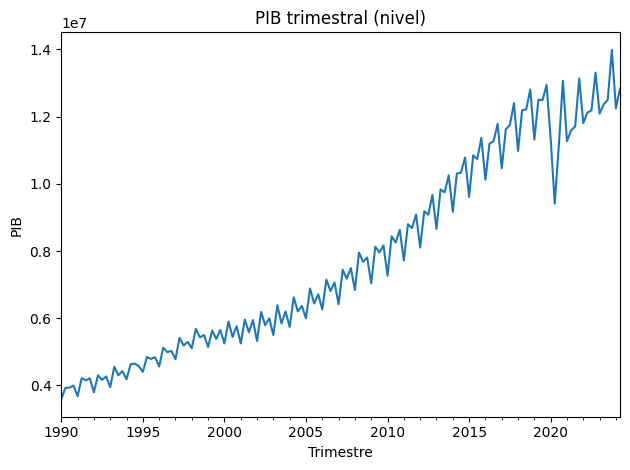

In [319]:
plt.figure()
df_q["pib"].plot()

plt.title("PIB trimestral (nivel)")
plt.xlabel("Trimestre"); plt.ylabel("PIB")
plt.tight_layout()
plt.savefig("output/figures/plot_pib_nivel.png", dpi=150)
plt.show()  # <- muestra en la celda

PIB acumulado (suma 4 trimestres)

In [320]:
df_q.head(8)

,fecha,pib,itcr,tc,inf,infe,pib_a
periodo_q,,,,,,,
1990Q1,1990-03-01,3.587595e+06,NaN,3.0703,NaN,NaN,NaN
1990Q2,1990-06-01,3.926068e+06,NaN,3.1477,NaN,NaN,NaN
1990Q3,1990-09-01,3.934133e+06,NaN,3.2410,NaN,NaN,NaN
1990Q4,1990-12-01,3.995340e+06,NaN,3.3748,NaN,NaN,1.544314e+07
1991Q1,1991-03-01,3.677806e+06,89.805307,3.5019,0.244011,5.779607,1.553335e+07
1991Q2,1991-06-01,4.217984e+06,88.664188,3.5740,0.233678,2.713131,1.582526e+07
1991Q3,1991-09-01,4.149575e+06,93.373602,3.6427,0.212258,2.907812,1.604071e+07
1991Q4,1991-12-01,4.211088e+06,94.696616,3.7258,0.145158,3.861125,1.625645e+07


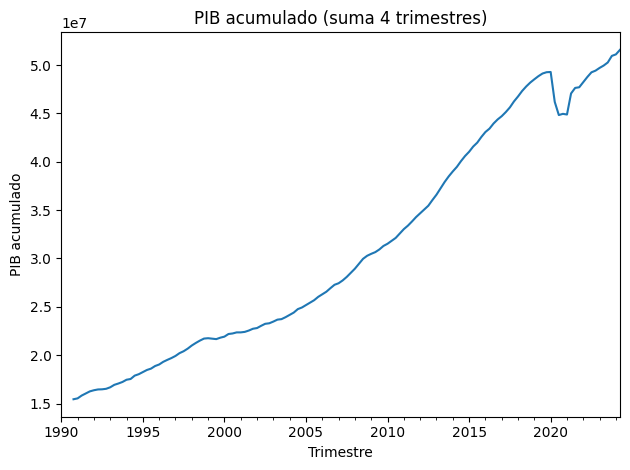

In [321]:
plt.figure()
df_q["pib_a"].plot()
plt.title("PIB acumulado (suma 4 trimestres)")
plt.xlabel("Trimestre"); plt.ylabel("PIB acumulado")
plt.tight_layout()
plt.savefig("output/figures/plot_pib_acumulado.png", dpi=150)
plt.show()


Histograma PIB trimestral

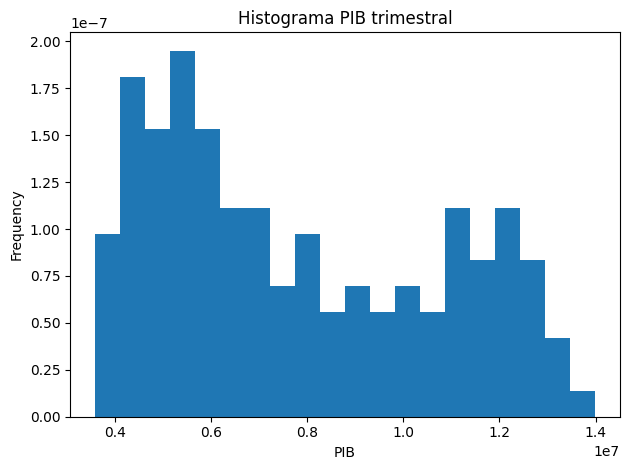

In [322]:
plt.figure()
df_q["pib"].dropna().plot(kind="hist", bins=20, density=True)
plt.title("Histograma PIB trimestral")
plt.xlabel("PIB")
plt.tight_layout()
plt.savefig("output/figures/hist_pib.png", dpi=150)
plt.show()

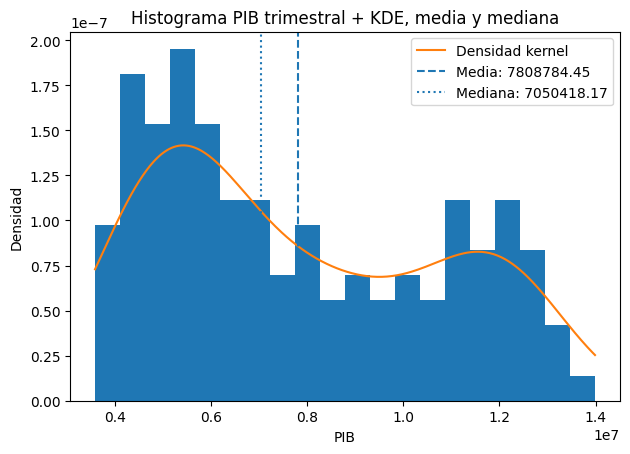

In [323]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Serie limpia
x = df_q["pib"].dropna().to_numpy()

# --- Histograma (densidad) ---
plt.figure()
plt.hist(x, bins=20, density=True)  # density=True para que el área sea 1

# --- KDE (línea kernel) ---
kde = gaussian_kde(x)               # bw_method='scott' (default) o 'silverman' o un float
xs = np.linspace(x.min(), x.max(), 400)
plt.plot(xs, kde(xs), label="Densidad kernel")

# --- Media y mediana ---
mu  = x.mean()
med = np.median(x)
plt.axvline(mu,  linestyle="--", linewidth=1.5, label=f"Media: {mu:.2f}")
plt.axvline(med, linestyle=":",  linewidth=1.5, label=f"Mediana: {med:.2f}")

# --- Rotulación y salida ---
plt.title("Histograma PIB trimestral + KDE, media y mediana")
plt.xlabel("PIB")
plt.ylabel("Densidad")
plt.legend(loc="best")
plt.tight_layout()

plt.savefig("output/figures/hist_pib_con_kde_media_mediana.png", dpi=150)
plt.show()


Histograma PIB acumulado (4T)

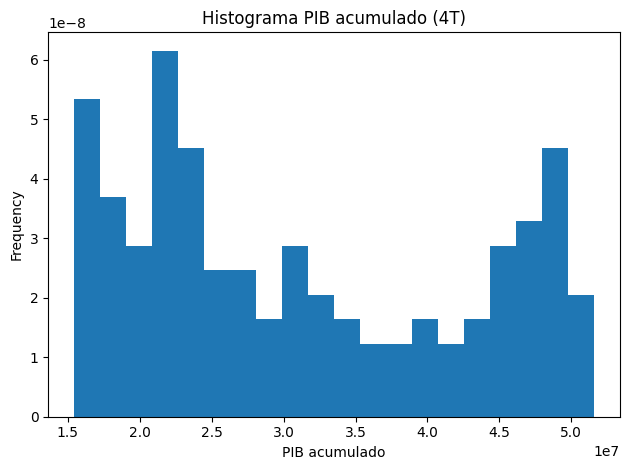

In [324]:
plt.figure()
df_q["pib_a"].dropna().plot(kind="hist", bins=20, density=True)
plt.title("Histograma PIB acumulado (4T)")
plt.xlabel("PIB acumulado")
plt.tight_layout()

plt.savefig("output/figures/hist_pib_a.png", dpi=150)
plt.show()


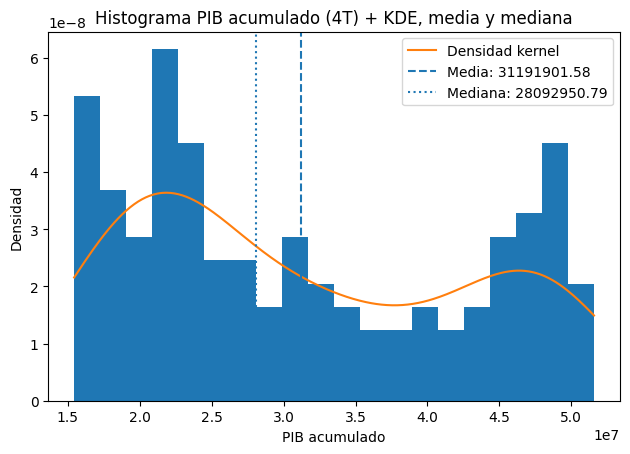

In [325]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Datos (PIB acumulado 4T) sin NaN
x = df_q["pib_a"].dropna().to_numpy()

plt.figure()
# Histograma en densidad para usar la misma escala que la KDE
plt.hist(x, bins=20, density=True)

# Densidad kernel
kde = gaussian_kde(x)  # bw_method='scott' (default) | 'silverman' | 0.5, 1.5, etc.
xs = np.linspace(x.min(), x.max(), 400)
plt.plot(xs, kde(xs), label="Densidad kernel")

# Media y mediana
mu  = x.mean()
med = np.median(x)
plt.axvline(mu,  linestyle="--", linewidth=1.5, label=f"Media: {mu:.2f}")
plt.axvline(med, linestyle=":",  linewidth=1.5, label=f"Mediana: {med:.2f}")

# Rotulación y salida
plt.title("Histograma PIB acumulado (4T) + KDE, media y mediana")
plt.xlabel("PIB acumulado")
plt.ylabel("Densidad")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("output/figures/hist_pib_a_con_kde_media_mediana.png", dpi=550)
plt.show() 



## 6) Diferencias y crecimientos (QoQ, YoY)

Fórmulas:
$$
\Delta PIB_t = PIB_t-PIB_{t-1},\quad
g_{QoQ}=\left(\frac{PIB_t}{PIB_{t-1}}-1\right)100,\quad
g_{YoY}=\left(\frac{PIB_t}{PIB_{t-4}}-1\right)100.
$$


In [326]:
s = df_q["pib"].astype(float)
df_q["dpib"] = s.diff(1)
df_q["g_qoq"] = (s / s.shift(1) - 1.0) * 100.0
df_q["g_yoy"] = (s / s.shift(4) - 1.0) * 100.0

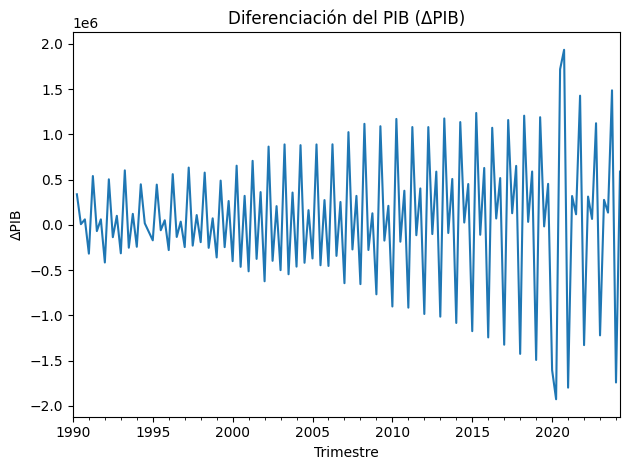

In [327]:
plt.figure()
df_q["dpib"].plot()
plt.title("Diferenciación del PIB (ΔPIB)")
plt.xlabel("Trimestre")
plt.ylabel("ΔPIB")
plt.tight_layout()
plt.savefig("output/figures/plot_dpib.png", dpi=150)
plt.show()

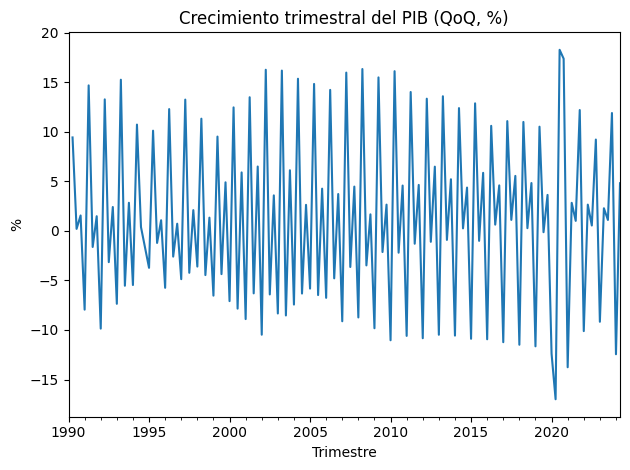

In [328]:
plt.figure()
df_q["g_qoq"].plot()
plt.title("Crecimiento trimestral del PIB (QoQ, %)")
plt.xlabel("Trimestre"); plt.ylabel("%")
plt.tight_layout() 
plt.savefig("output/figures/plot_g_qoq.png", dpi=150)
plt.show()

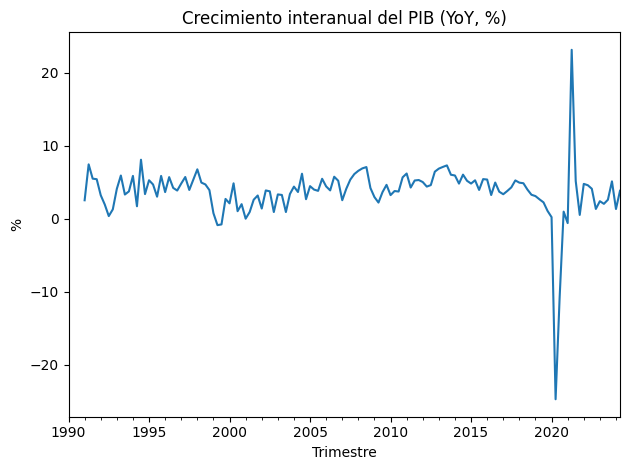

In [329]:
plt.figure()
df_q["g_yoy"].plot()
plt.title("Crecimiento interanual del PIB (YoY, %)")
plt.xlabel("Trimestre"); plt.ylabel("%")
plt.tight_layout() 
plt.savefig("output/figures/plot_g_yoy.png", dpi=150)
plt.show()

In [330]:
df_q[["dpib","g_qoq","g_yoy"]].tail()


,dpib,g_qoq,g_yoy
periodo_q,,,
2023Q2,2.765541e+05,2.287781,2.025733
2023Q3,1.364004e+05,1.103128,2.591731
2023Q4,1.487474e+06,11.898585,5.107274
2024Q1,-1.741560e+06,-12.449728,1.314230
2024Q2,5.895351e+05,4.813639,3.816048


In [331]:
df_q.to_csv("output/tables/m1_q_pib.csv", index=True)


## 7) Normalizaciones: Z-score y Min‑Max


In [332]:
from utils.func import zscore, minmax01

In [333]:
def zscore(x):
    x = x.astype(float)
    return (x - x.mean()) / x.std(ddof=1)

In [334]:
def minmax01(x):
    x = x.astype(float)
    return (x - x.min()) / (x.max() - x.min())

Aplicamos las funciones `zscore()` y `minmax01()` a la columna `pib`.

In [335]:
df_q["pib_z"] = zscore(df_q["pib"])

In [336]:
df_q["pib_minmax"] = minmax01(df_q["pib"])

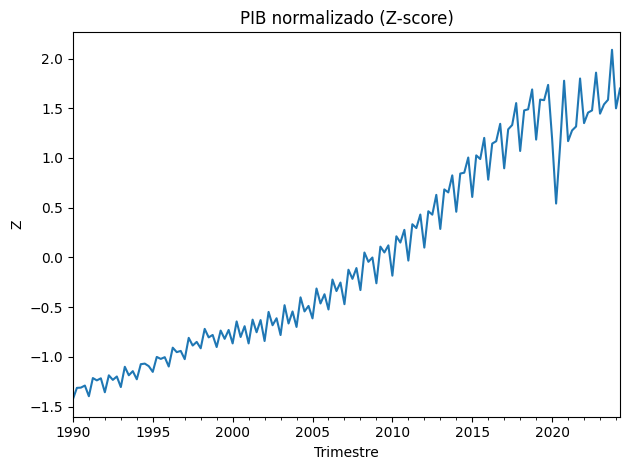

In [337]:
plt.figure(); df_q["pib_z"].plot()
plt.title("PIB normalizado (Z-score)")
plt.xlabel("Trimestre"); plt.ylabel("Z")
plt.tight_layout() 
plt.savefig("output/figures/plot_pib_z.png", dpi=150)
plt.show()

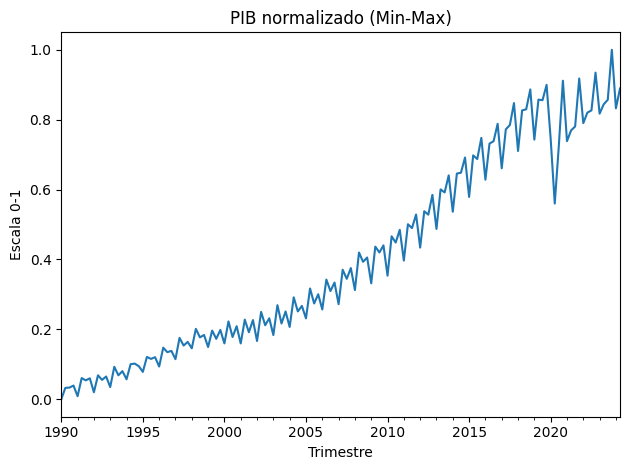

In [338]:
plt.figure(); df_q["pib_minmax"].plot()
plt.title("PIB normalizado (Min-Max)")
plt.xlabel("Trimestre"); plt.ylabel("Escala 0-1")
plt.tight_layout() 
plt.savefig("output/figures/plot_pib_minmax.png", dpi=150)
plt.show()

Observamos las primeras filas del DataFrame con las nuevas columnas.

In [339]:
df_q[["pib_z","pib_minmax"]].head()

,pib_z,pib_minmax
periodo_q,,
1990Q1,-1.426142,0.000000
1990Q2,-1.311788,0.032542
1990Q3,-1.309064,0.033317
1990Q4,-1.288384,0.039202
1991Q1,-1.395664,0.008673



## 8) Transformaciones: log, raíz cuadrada y Box‑Cox


In [340]:
from scipy import stats

# Transformaciones básicas sobre el PIB
df_q["log_pib"]  = np.log(df_q["pib"])     # log natural; útil para estabilizar varianza (efectos multiplicativos)
df_q["sqrt_pib"] = np.sqrt(df_q["pib"])    # raíz cuadrada; alternativa más suave que el log

# Box–Cox (requiere valores estrictamente > 0)
pib_pos = df_q["pib"].dropna().astype(float)           # serie sin NaN y como float
bc_vals, bc_lambda = stats.boxcox(pib_pos.values)      # estima λ por máx. verosimilitud y aplica T_λ(y)
df_q.loc[pib_pos.index, "bc_pib"] = bc_vals            # asigna la serie transformada respetando el índice original

# (opcional) inspeccionar el λ estimado para documentación
# print(f"λ Box–Cox ≈ {float(bc_lambda):.3f}")

# Nota: si tuvieras ceros/negativos en PIB, Box–Cox falla.
#       Alternativas: desplazar y -> y + c (c>0) o usar Yeo–Johnson (admite y ≤ 0).



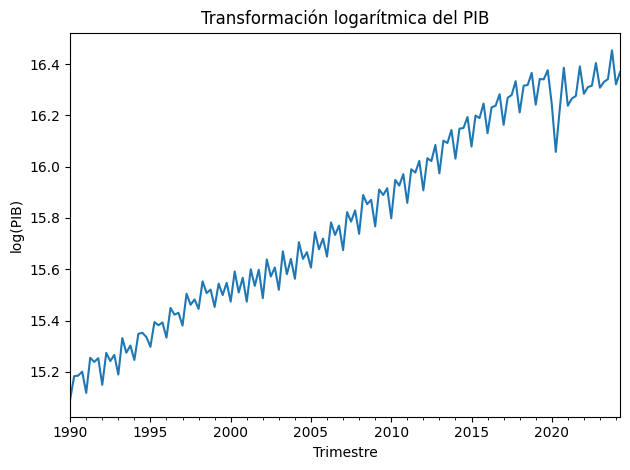

In [341]:
plt.figure(); df_q["log_pib"].plot()
plt.title("Transformación logarítmica del PIB")
plt.xlabel("Trimestre"); plt.ylabel("log(PIB)")
plt.tight_layout()
plt.savefig("output/figures/plot_log_pib.png", dpi=150)
plt.show()

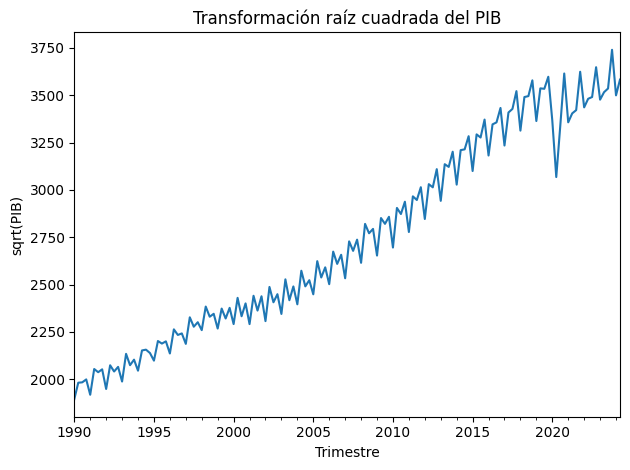

In [342]:
plt.figure(); df_q["sqrt_pib"].plot()
plt.title("Transformación raíz cuadrada del PIB")
plt.xlabel("Trimestre"); plt.ylabel("sqrt(PIB)")
plt.tight_layout()
plt.savefig("output/figures/plot_sqrt_pib.png", dpi=150)
plt.show()

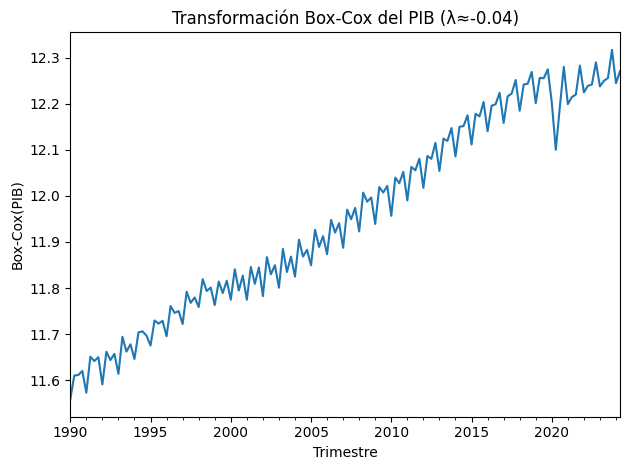

In [343]:
plt.figure(); df_q["bc_pib"].plot()
plt.title(f"Transformación Box-Cox del PIB (λ≈{bc_lambda:.2f})")
plt.xlabel("Trimestre"); plt.ylabel("Box-Cox(PIB)")
plt.tight_layout()
plt.savefig("output/figures/plot_boxcox_pib.png", dpi=150)
plt.show()

In [344]:
bc_lambda

np.float64(-0.0370773805680996)

In [345]:
df_q

,fecha,pib,itcr,tc,inf,infe,pib_a,dpib,g_qoq,g_yoy,pib_z,pib_minmax,log_pib,sqrt_pib,bc_pib
periodo_q,,,,,,,,,,,,,,,
1990Q1,1990-03-01,3.587595e+06,NaN,3.0703,NaN,NaN,NaN,NaN,NaN,NaN,-1.426142,0.000000,15.092993,1894.094844,11.558728
1990Q2,1990-06-01,3.926068e+06,NaN,3.1477,NaN,NaN,NaN,3.384731e+05,9.434540,NaN,-1.311788,0.032542,15.183149,1981.430892,11.610160
1990Q3,1990-09-01,3.934133e+06,NaN,3.2410,NaN,NaN,NaN,8.064230e+03,0.205402,NaN,-1.309064,0.033317,15.185201,1983.464799,11.611328
1990Q4,1990-12-01,3.995340e+06,NaN,3.3748,NaN,NaN,1.544314e+07,6.120758e+04,1.555809,NaN,-1.288384,0.039202,15.200639,1998.834709,11.620118
1991Q1,1991-03-01,3.677806e+06,89.805307,3.5019,0.244011,5.779607,1.553335e+07,-3.175344e+05,-7.947619,2.514512,-1.395664,0.008673,15.117827,1917.760619,11.572912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023Q2,2023-06-01,1.236487e+07,60.059236,6.9600,0.027253,0.031615,4.994764e+07,2.765541e+05,2.287781,2.025733,1.539287,0.843875,16.330370,3516.371124,12.249830
2023Q3,2023-09-01,1.250127e+07,60.008669,6.9600,0.028478,0.045683,5.026346e+07,1.364004e+05,1.103128,2.591731,1.585370,0.856989,16.341340,3535.712974,12.255817
2023Q4,2023-12-01,1.398874e+07,60.180628,6.9600,0.021183,0.046211,5.094318e+07,1.487474e+06,11.898585,5.107274,2.087918,1.000000,16.453763,3740.152403,12.317026



## 9) Volatilidad: desviación estándar móvil del crecimiento YoY


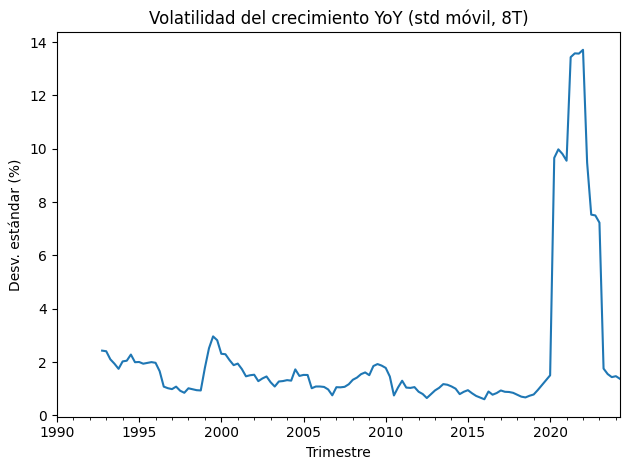

In [346]:

# Desv. estándar móvil de 8 trimestres sobre el crecimiento interanual (YoY)
df_q["vol_yoy_std8"] = df_q["g_yoy"].rolling(8).std()

# Figura: traza la serie de volatilidad (std móvil)
plt.figure()
df_q["vol_yoy_std8"].plot()
plt.title("Volatilidad del crecimiento YoY (std móvil, 8T)")
plt.xlabel("Trimestre")              # eje X en trimestres (índice PeriodIndex)
plt.ylabel("Desv. estándar (%)")     # unidades en puntos porcentuales
plt.tight_layout()
plt.savefig("output/figures/plot_volatilidad.png", dpi=150)  # guarda PNG en /out
plt.show()                           # muestra el gráfico en la celda/ventana


In [347]:
df_q[["g_yoy","vol_yoy_std8"]].tail()

,g_yoy,vol_yoy_std8
periodo_q,,
2023Q2,2.025733,1.758620
2023Q3,2.591731,1.553555
2023Q4,5.107274,1.438088
2024Q1,1.314230,1.473821
2024Q2,3.816048,1.373421



## 10) Picos y valles (ciclos) — heurística `find_peaks`
Detectamos **picos** sobre el nivel del PIB y **valles** sobre la serie negativa.


In [348]:
from scipy.signal import find_peaks  # detección de máximos locales

# Serie base: PIB en nivel, sin NaN y como float
series = df_q["pib"].astype(float).dropna()

# Detecta picos (máximos locales) en la serie
# 'distance=3' exige al menos 3 trimestres entre picos para evitar detecciones muy cercanas
peaks_idx, _ = find_peaks(series.values, distance=3)

# Detecta valles (mínimos locales) aplicando find_peaks a la serie invertida
troughs_idx, _ = find_peaks((-series).values, distance=3)

# Convierte los índices (posiciones) a observaciones con PeriodIndex y valores
peaks = series.iloc[peaks_idx]
troughs = series.iloc[troughs_idx]

# Construye tabla ordenada de puntos de giro (picos y valles)
turning_points = pd.DataFrame({
    "tipo": ["pico"]*len(peaks) + ["valle"]*len(troughs),
    "periodo": list(peaks.index.astype(str)) + list(troughs.index.astype(str)),
    "pib": list(peaks.values) + list(troughs.values)
}).sort_values("periodo").reset_index(drop=True)

turning_points  # muestra la tabla resultante


,tipo,periodo,pib
0,valle,1991Q1,3.677806e+06
1,pico,1991Q2,4.217984e+06
2,valle,1992Q1,3.795756e+06
3,pico,1992Q2,4.299703e+06
4,valle,1993Q1,3.950724e+06
...,...,...,...
62,valle,2022Q1,1.180625e+07
63,pico,2022Q4,1.330901e+07
64,valle,2023Q1,1.208831e+07
65,pico,2023Q4,1.398874e+07


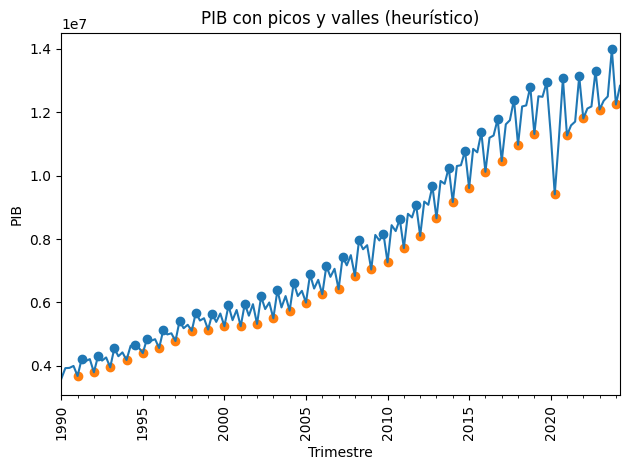

In [349]:
plt.figure(); series.plot()
plt.scatter(peaks.index.astype(str), peaks.values)
plt.scatter(troughs.index.astype(str), troughs.values)
plt.title("PIB con picos y valles (heurístico)")
plt.xlabel("Trimestre"); plt.ylabel("PIB")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("output/figures/plot_picos_valles.png", dpi=150)
plt.show()



## 11) Outliers por IQR (en el nivel del PIB)


In [350]:
# --- Outliers por IQR con diagnósticos y gráfico ---
# Sugerencia: detectar outliers en cambios (log-diff o YoY), no en niveles.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetros
series_col   = "pib"     # columna base
transform    = "logdiff" # 'level' | 'logdiff' | 'yoy'
k            = 1.5       # multiplicador del IQR (prueba 1.0 si quieres más sensibilidad)

# 1) Elegir la serie a evaluar
s = df_q[series_col].astype(float)

if transform == "level":
    x = s.copy()
    y_label = "PIB (nivel)"
    title_suf = "Nivel"
elif transform == "logdiff":
    # Δlog PIB (aprox variación porcentual trimestral)
    x = np.log(s).diff()
    y_label = "Δlog(PIB)"
    title_suf = "Δlog trimestral"
elif transform == "yoy":
    # Crecimiento interanual
    x = s.pct_change(4)
    y_label = "Crecimiento YoY"
    title_suf = "YoY"
else:
    raise ValueError("transform debe ser 'level', 'logdiff' o 'yoy'.")

# 2) Q1, Q3, IQR y límites (quitamos NaN generados por diferencias)
x_clean = x.dropna()
q1, q3  = x_clean.quantile(0.25), x_clean.quantile(0.75)
iqr     = q3 - q1
lb, ub  = q1 - k*iqr, q3 + k*iqr

# 3) Detección (sobre el índice alineado de df_q)
mask_out = (x < lb) | (x > ub)
outliers = pd.DataFrame({
    "serie_eval": x,
    "is_outlier": mask_out
}).loc[mask_out.fillna(False)]

# 4) Diagnóstico rápido en consola (útil para entender por qué no aparecen)
print(f"[{title_suf}] n={len(x_clean)}, Q1={q1:.4f}, Q3={q3:.4f}, IQR={iqr:.4f}, lb={lb:.4f}, ub={ub:.4f}")
print(f"Outliers detectados: {outliers.shape[0]}")

# 5) Exportar límites y outliers 

pd.DataFrame(
    {"transform":[transform], "k":[k], "q1":[q1], "q3":[q3], "iqr":[iqr], "lb":[lb], "ub":[ub]}
).to_csv(f"output/tables/iqr_bounds_{transform}.csv", index=False)

outliers.rename(columns={"serie_eval": f"{series_col}_{transform}"}, inplace=True)
outliers.to_csv(f"output/tables/outliers_{series_col}_{transform}.csv")



[Δlog trimestral] n=137, Q1=-0.0651, Q3=0.0882, IQR=0.1533, lb=-0.2951, ub=0.3182
Outliers detectados: 0


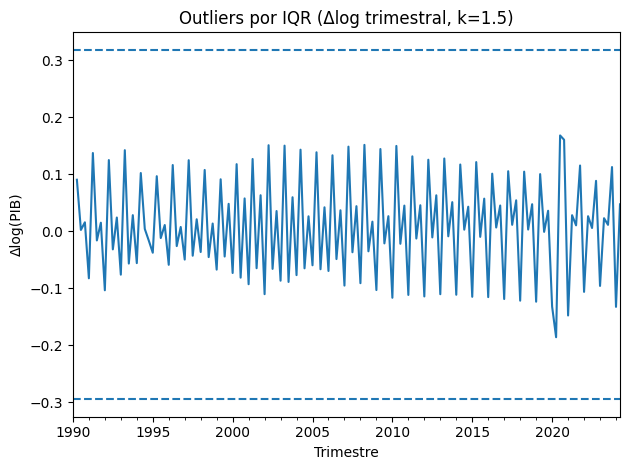

In [351]:
# 6) Gráfico: serie transformada + puntos outliers + bandas IQR
plt.figure()
x.plot()                        # serie evaluada
if not outliers.empty:
    plt.plot(outliers.index, outliers[f"{series_col}_{transform}"],
             linestyle="none", marker="o")  # marcadores de outliers
plt.axhline(lb, linestyle="--") # banda inferior
plt.axhline(ub, linestyle="--") # banda superior
plt.title(f"Outliers por IQR ({title_suf}, k={k})")
plt.xlabel("Trimestre")
plt.ylabel(y_label)
plt.tight_layout()
plt.savefig(f"data/{series_col}_outliers_{transform}.png", dpi=150)
plt.show()




In [352]:
# 7) Mostrar tabla (si hay)
outliers.head()

,pib_logdiff,is_outlier
periodo_q,,



## 12) Medias móviles (4T y 8T)


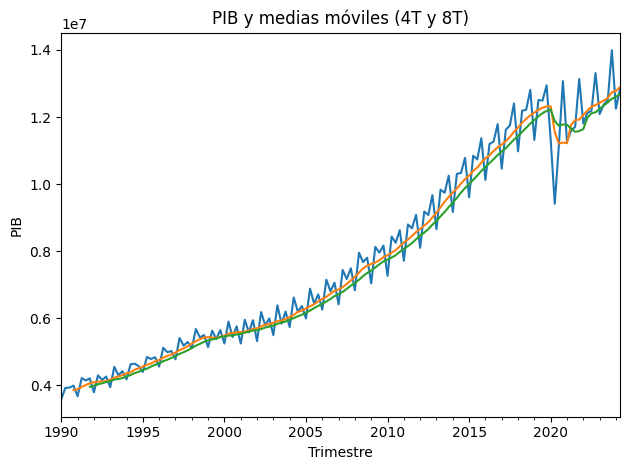

,pib,mm4,mm8
periodo_q,,,
2023Q2,1.236487e+07,1.248691e+07,1.233933e+07
2023Q3,1.250127e+07,1.256586e+07,1.243867e+07
2023Q4,1.398874e+07,1.273580e+07,1.254541e+07
2024Q1,1.224718e+07,1.277551e+07,1.260052e+07
2024Q2,1.283672e+07,1.289348e+07,1.269019e+07


In [56]:

df_q["mm4"] = df_q["pib"].rolling(4).mean()
df_q["mm8"] = df_q["pib"].rolling(8).mean()

plt.figure(); df_q["pib"].plot(); df_q["mm4"].plot(); df_q["mm8"].plot()
plt.title("PIB y medias móviles (4T y 8T)")
plt.xlabel("Trimestre"); plt.ylabel("PIB")
plt.tight_layout(); plt.savefig("output/figures/plot_medias_moviles.png", dpi=150); plt.show()

df_q[["pib","mm4","mm8"]].tail()



## 13) Brecha del PIB (HP filter, λ=1600)


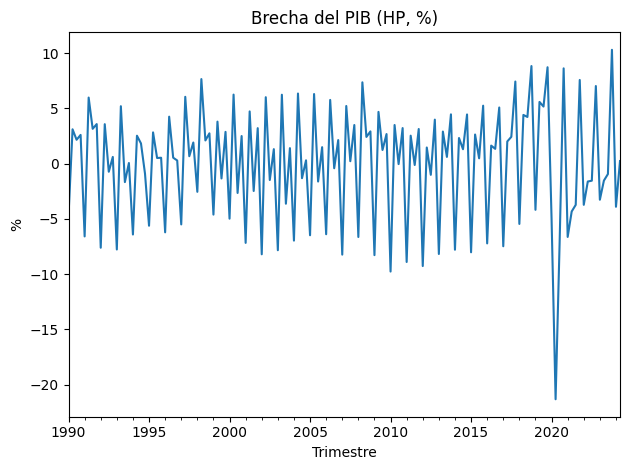

,pib,pib_trend_hp,gap_hp_pct
periodo_q,,,
2023Q2,1.236487e+07,1.255797e+07,-1.537684
2023Q3,1.250127e+07,1.262019e+07,-0.942322
2023Q4,1.398874e+07,1.268266e+07,10.298153
2024Q1,1.224718e+07,1.274486e+07,-3.904927
2024Q2,1.283672e+07,1.280707e+07,0.231451


In [57]:

from statsmodels.tsa.filters.hp_filter import hpfilter

cycle, trend = hpfilter(df_q["pib"].astype(float), lamb=1600)
df_q["pib_trend_hp"] = trend
df_q["gap_hp_pct"] = (df_q["pib"] - df_q["pib_trend_hp"]) / df_q["pib_trend_hp"] * 100.0

plt.figure(); df_q["gap_hp_pct"].plot()
plt.title("Brecha del PIB (HP, %)")
plt.xlabel("Trimestre"); plt.ylabel("%")
plt.tight_layout(); plt.savefig("output/figures/plot_gap_hp.png", dpi=150); plt.show()

df_q[["pib","pib_trend_hp","gap_hp_pct"]].tail()



## 14) Cambio de régimen: sup‑F (quiebre en nivel con dummy)

Modelo: $PIB_t = a + bt + c\cdot D_{break} + \varepsilon_t$. Exploramos el mejor quiebre dejando 8T de margen.


In [77]:
import statsmodels.api as sm  # Importa la librería statsmodels para estimar modelos OLS y hacer tests

# Extrae la columna "pib" del DataFrame df_q, eliminando valores nulos y asegurando que sea tipo float
y = df_q["g_yoy"].dropna().astype(float)

# Crea una variable temporal t = [0, 1, 2, ..., n-1], usada como regresor para capturar tendencia
t = np.arange(len(y), dtype=float)

# Construye la matriz de regresores base: una constante (intercepto) y la variable de tiempo t
X_base = sm.add_constant(t)

# Define la función que ejecuta un Chow test supervisado (Sup-F) para encontrar el mejor punto de quiebre
def chow_supF(y, X_base, min_seg=8):
    n = len(y)  # número total de observaciones
    best = {"k": None, "F": -np.inf}  # inicializa el mejor resultado como vacío, F-value muy bajo

    # Itera sobre posibles puntos de quiebre, dejando fuera los extremos definidos por min_seg
    for k in range(min_seg, n - min_seg):
        D = np.zeros(n)      # crea un vector dummy de ceros
        D[k+1:] = 1.0        # asigna 1 desde el punto k+1 en adelante (representa el cambio estructural)

        # Construye la nueva matriz de regresores: [constante, t, D]
        X = np.column_stack([X_base, D])

        # Estima el modelo de regresión: y = beta0 + beta1*t + beta2*D + e
        res = sm.OLS(y, X).fit()

        # Testea si beta2 (coeficiente de D) es significativamente distinto de 0 con un F-test
        f_test = res.f_test(np.array([[0, 0, 1]]))
        F = float(f_test.fvalue)  # extrae el valor F del test

        # Si este F-value es mayor que el mejor anterior, lo guarda como el nuevo óptimo
        if F > best["F"]:
            best.update({"k": k, "F": F, "res": res})  # guarda el mejor punto k, el valor F y el modelo estimado

    return best  # devuelve el mejor punto de quiebre encontrado

# Ejecuta la función de búsqueda de quiebre estructural en la serie y
best_break = chow_supF(y.values, X_base, min_seg=8)

# Extrae el índice del mejor quiebre, el valor F y el período calendario correspondiente
k = best_break["k"]
Fval = best_break["F"]
break_period = y.index[k]

# Guarda los resultados en un archivo JSON para documentar el quiebre identificado
with open("output/tables/break_result.json", "w") as f:
    json.dump({"break_index": int(k), "break_period": str(break_period), "F": Fval}, f, indent=2)

# También imprime (o retorna) el resultado como diccionario para inspección directa
{"break_period": str(break_period), "F": Fval}


{'break_period': '2018Q4', 'F': 10.880169889221108}

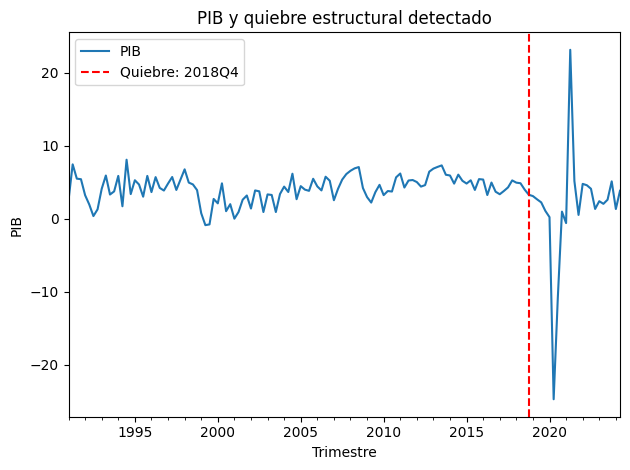

In [78]:
plt.figure()
y.plot(label="PIB")
plt.axvline(break_period, color="red", linestyle="--", label=f"Quiebre: {break_period}")
plt.title("PIB y quiebre estructural detectado")
plt.xlabel("Trimestre")
plt.ylabel("PIB")
plt.legend()
plt.tight_layout()
plt.show()



## 15) Rachas de expansión/contracción (QoQ)


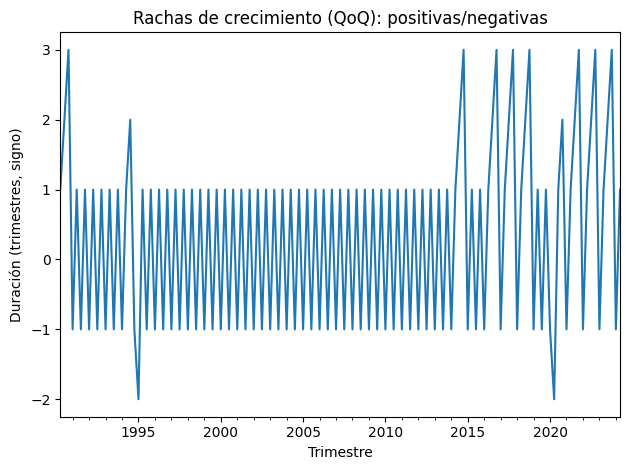

,g_qoq,runs_qoq
periodo_q,,
1990Q2,9.434540,1.0
1990Q3,0.205402,2.0
1990Q4,1.555809,3.0
1991Q1,-7.947619,-1.0
1991Q2,14.687522,1.0


In [67]:
# Extrae la columna "g_qoq" (crecimiento trimestre a trimestre) y elimina valores nulos
g = df_q["g_qoq"].dropna()

# Obtiene el signo de cada observación: +1 si es positivo, -1 si es negativo, 0 si es cero
sign = np.sign(g.values)

# Crea un array del mismo tamaño que 'sign' pero lleno de ceros, tipo entero
# Este array almacenará la duración de las rachas
runs = np.zeros_like(sign, dtype=int)

# Inicializa un contador de rachas
curr = 0

# Itera sobre cada elemento del array 'sign'
for i, sgn in enumerate(sign):
    
    # Si es el primer elemento, o si el signo cambió respecto al anterior, o si es cero:
    # reinicia la racha a 1
    if i == 0 or np.sign(sign[i]) != np.sign(sign[i-1]) or sgn == 0:
        curr = 1
    else:
        # Si continúa la misma racha (mismo signo), incrementa el contador
        curr += 1

    # Asigna al array 'runs' el valor de la racha actual, con el signo correspondiente:
    # positivo si es racha de crecimiento, negativo si es caída
    runs[i] = curr * (1 if sgn > 0 else -1 if sgn < 0 else 0)

# Convierte el array 'runs' en una Serie de Pandas, con el mismo índice que 'g'
runs_ser = pd.Series(runs, index=g.index, name="runs_qoq")

# Agrega la Serie 'runs_qoq' al DataFrame original
df_q["runs_qoq"] = runs_ser

# --- GRAFICAR ---

# Crea figura y grafica la serie de rachas
plt.figure()
runs_ser.plot()

# Añade título y etiquetas a los ejes
plt.title("Rachas de crecimiento (QoQ): positivas/negativas")
plt.xlabel("Trimestre")
plt.ylabel("Duración (trimestres, signo)")

# Ajusta la distribución del gráfico y guarda la imagen en disco
plt.tight_layout()
plt.savefig("output/figures/plot_rachas.png", dpi=150)

# Muestra la gráfica en pantalla
plt.show()

# Muestra las primeras filas con la tasa de crecimiento y su racha correspondiente
df_q[["g_qoq","runs_qoq"]].dropna().head()



## 16) Índice Base 100


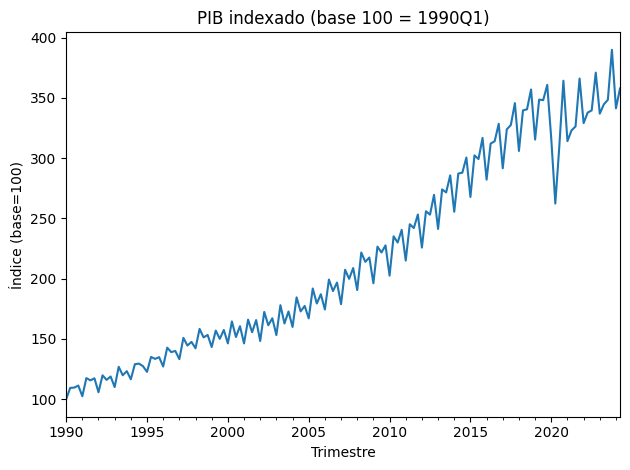

,pib,pib_base100
periodo_q,,
1990Q1,3.587595e+06,100.000000
1990Q2,3.926068e+06,109.434540
1990Q3,3.934133e+06,109.659321
1990Q4,3.995340e+06,111.365410
1991Q1,3.677806e+06,102.514512


In [60]:
# Tomamos el primer período del índice (el más antiguo) como base del índice 100
base_period = df_q.index.min()

# Construimos el índice del PIB con base 100 en base_period:
# (valor actual / valor en el período base) * 100
df_q["pib_base100"] = 100.0 * df_q["pib"] / df_q.loc[base_period, "pib"]

# --- Gráfico del PIB indexado ---
plt.figure()                             # crea una nueva figura
df_q["pib_base100"].plot()               # grafica la serie indexada
plt.title(f"PIB indexado (base 100 = {base_period})")  # título con la base usada
plt.xlabel("Trimestre")                  # etiqueta del eje X
plt.ylabel("Índice (base=100)")          # etiqueta del eje Y
plt.tight_layout()                       # ajusta márgenes para que no se corte nada
plt.savefig("output/figures/plot_base100.png", dpi=150)  # guarda el gráfico en PNG
plt.show()                              # cierra la figura para liberar memoria

# Vista rápida para verificar: primeras filas con el PIB original y el indexado
df_q[["pib", "pib_base100"]].head()



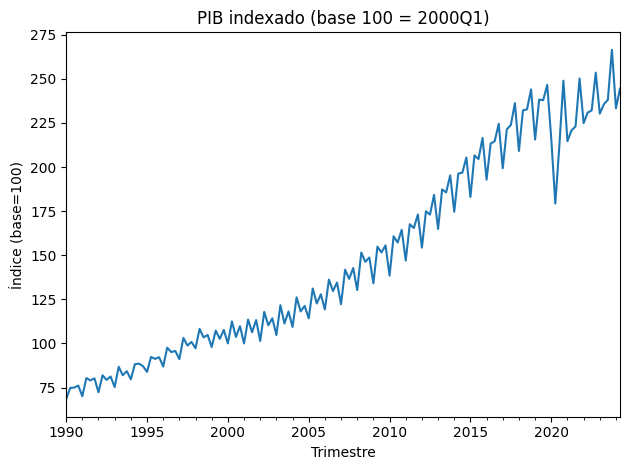

,pib,pib_base100
periodo_q,,
1990Q1,3.587595e+06,68.341420
1990Q2,3.926068e+06,74.789118
1990Q3,3.934133e+06,74.942737
1990Q4,3.995340e+06,76.108702
1991Q1,3.677806e+06,70.059873


In [68]:
# Establece manualmente el nuevo período base (¡asegúrate de que existe en el índice!)
nuevo_base = "2000Q1"

# Verifica que el nuevo base esté en el índice
if nuevo_base in df_q.index:
    df_q["pib_base100"] = 100.0 * df_q["pib"] / df_q.loc[nuevo_base, "pib"]
else:
    raise ValueError(f"El período base '{nuevo_base}' no se encuentra en el índice del DataFrame.")

# --- Gráfico del PIB indexado con nueva base ---
plt.figure()
df_q["pib_base100"].plot()
plt.title(f"PIB indexado (base 100 = {nuevo_base})")
plt.xlabel("Trimestre")
plt.ylabel("Índice (base=100)")
plt.tight_layout()
plt.savefig("output/figures/plot_base100_nueva_base.png", dpi=150)
plt.show()

# Ver las primeras filas
df_q[["pib", "pib_base100"]].head()



## 17) Correlación con rezagos (\(PIB_t\) vs \(PIB_{t-1}\))


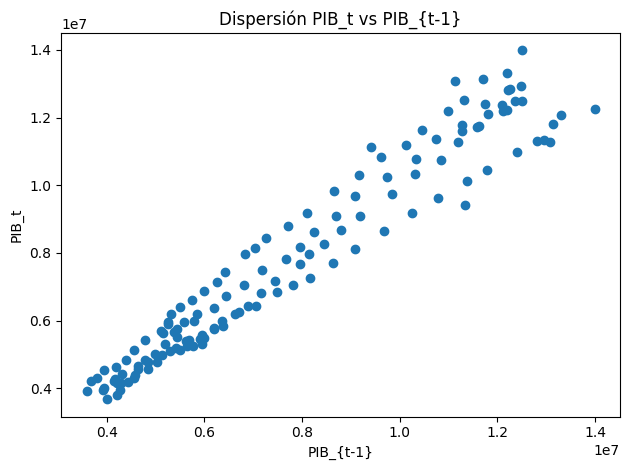

np.float64(0.967994112156338)

In [65]:
y = df_q["pib"].astype(float).dropna()
y_lag = y.shift(1).dropna()
common = y.index.intersection(y_lag.index)

plt.figure(); plt.scatter(y_lag.loc[common].values, y.loc[common].values)
plt.title("Dispersión PIB_t vs PIB_{t-1}")
plt.xlabel("PIB_{t-1}"); plt.ylabel("PIB_t")
plt.tight_layout(); plt.savefig("output/figures/plot_scatter_lag.png", dpi=150); 
plt.show()

corr = y.loc[common].corr(y_lag.loc[common]); corr



## 18) Desviación estandarizada del crecimiento YoY (z‑score)


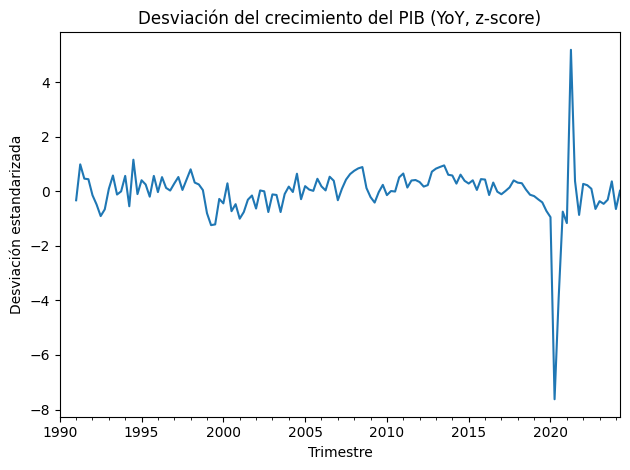

,g_yoy,g_yoy_z
periodo_q,,
2023Q2,2.025733,-0.458054
2023Q3,2.591731,-0.306525
2023Q4,5.107274,0.366939
2024Q1,1.314230,-0.648539
2024Q2,3.816048,0.021251


In [64]:

def zscore_series(s):
    s = s.dropna().astype(float)
    return (s - s.mean()) / s.std(ddof=1)

df_q["g_yoy_z"] = zscore_series(df_q["g_yoy"])

plt.figure(); df_q["g_yoy_z"].plot()
plt.title("Desviación del crecimiento del PIB (YoY, z-score)")
plt.xlabel("Trimestre"); plt.ylabel("Desviación estandarizada")
plt.tight_layout(); plt.savefig("output/figures/plot_g_yoy_z.png", dpi=150); 
plt.show()

df_q[["g_yoy","g_yoy_z"]].tail()



## 19) Export final de resultados
Guardamos un CSV consolidado con todas las columnas clave para informes posteriores.


In [63]:

export_cols = [
    "fecha","pib","pib_a","dpib","g_qoq","g_yoy","pib_z","pib_minmax",
    "log_pib","sqrt_pib","bc_pib","vol_yoy_std8","pib_trend_hp",
    "gap_hp_pct","mm4","mm8","runs_qoq","pib_base100","g_yoy_z"
]
df_export = df_q[export_cols].copy()
csv_path = "output/m1_resultados_pipeline.csv"
df_export.to_csv(csv_path)
csv_path, df_export.tail()

df_export

,fecha,pib,pib_a,dpib,g_qoq,g_yoy,pib_z,pib_minmax,log_pib,sqrt_pib,bc_pib,vol_yoy_std8,pib_trend_hp,gap_hp_pct,mm4,mm8,runs_qoq,pib_base100,g_yoy_z
periodo_q,,,,,,,,,,,,,,,,,,,
1990Q1,1990-03-01,3.587595e+06,NaN,NaN,NaN,NaN,-1.426142,0.000000,15.092993,1894.094844,11.558728,NaN,3.764382e+06,-4.696302,NaN,NaN,NaN,100.000000,NaN
1990Q2,1990-06-01,3.926068e+06,NaN,3.384731e+05,9.434540,NaN,-1.311788,0.032542,15.183149,1981.430892,11.610160,NaN,3.807765e+06,3.106902,NaN,NaN,1.0,109.434540,NaN
1990Q3,1990-09-01,3.934133e+06,NaN,8.064230e+03,0.205402,NaN,-1.309064,0.033317,15.185201,1983.464799,11.611328,NaN,3.851037e+06,2.157741,NaN,NaN,2.0,109.659321,NaN
1990Q4,1990-12-01,3.995340e+06,1.544314e+07,6.120758e+04,1.555809,NaN,-1.288384,0.039202,15.200639,1998.834709,11.620118,NaN,3.894162e+06,2.598189,3.860784e+06,NaN,3.0,111.365410,NaN
1991Q1,1991-03-01,3.677806e+06,1.553335e+07,-3.175344e+05,-7.947619,2.514512,-1.395664,0.008673,15.117827,1917.760619,11.572912,NaN,3.937156e+06,-6.587250,3.883337e+06,NaN,-1.0,102.514512,-0.327198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023Q2,2023-06-01,1.236487e+07,4.994764e+07,2.765541e+05,2.287781,2.025733,1.539287,0.843875,16.330370,3516.371124,12.249830,1.758620,1.255797e+07,-1.537684,1.248691e+07,1.233933e+07,1.0,344.656098,-0.458054
2023Q3,2023-09-01,1.250127e+07,5.026346e+07,1.364004e+05,1.103128,2.591731,1.585370,0.856989,16.341340,3535.712974,12.255817,1.553555,1.262019e+07,-0.942322,1.256586e+07,1.243867e+07,2.0,348.458097,-0.306525
2023Q4,2023-12-01,1.398874e+07,5.094318e+07,1.487474e+06,11.898585,5.107274,2.087918,1.000000,16.453763,3740.152403,12.317026,1.438088,1.268266e+07,10.298153,1.273580e+07,1.254541e+07,3.0,389.919679,0.366939
